In [8]:
import matplotlib.pyplot as plt
from data_type import get_converted_incidents_df
import numpy as np
import matplotlib.pyplot as plt

### In questo notebook vengono poste a null gli attributi che sono inconsistenti della tabella incidents.csv

In [9]:
df = get_converted_incidents_df()
nullCount_beforeProcessing = df.isnull().sum()

In [10]:
### Rimozione duplicati

In [11]:
before = df.shape
df.drop_duplicates(inplace=True)
after = df.shape

print("Prima della rimozione: ", before)
print("Dopo la rimozione: ", after)
print("Lost rows: ", (before[0]-after[0])/before[0]*100, "%")

Prima della rimozione:  (239677, 28)
Dopo la rimozione:  (239381, 28)
Lost rows:  0.12349954313513604 %


#### Controllo consistenza dei valori numerici

In [12]:
df.loc[(df['min_age_participants'] < 0) | (df['min_age_participants'] > 122), 'min_age_participants'] = np.nan
df.loc[(df['max_age_participants'] < 0) | (df['max_age_participants'] > 122), 'max_age_participants'] = np.nan
df.loc[(df['avg_age_participants'] < 0) | (df['avg_age_participants'] > 122), 'avg_age_participants'] = np.nan

cols = ['n_participants_adult', 'n_participants_child', 'n_participants_teen', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants']
for col in cols:
    df.loc[(df[col] < 0) | (df[col] > 103), col] = np.nan


after = df.isnull().sum()
print("Percentuale valori eliminati: ")
print(after-nullCount_beforeProcessing)

Percentuale valori eliminati: 
date                             0
state                            0
city_or_county                   0
address                        -50
latitude                         0
longitude                        0
congressional_district          -1
state_house_district           -39
state_senate_district          -29
participant_age1              -277
participant_age_group1        -246
participant_gender1           -247
min_age_participants         11468
avg_age_participants         11514
max_age_participants         11429
n_participants_child          -236
n_participants_teen           -233
n_participants_adult          -232
n_males                       -247
n_females                     -247
n_killed                         0
n_injured                        0
n_arrested                    -233
n_unharmed                    -233
n_participants                   0
notes                         -194
incident_characteristics1        0
incident_characteristics

In [13]:
inconsistent_entry = df.loc[df['date'].dt.year.isin([2013,2028, 2029, 2030]), 'date']
print(len(inconsistent_entry))
print(inconsistent_entry)
df.loc[df['date'].dt.year.isin([2013,2028, 2029, 2030]), 'date'] = np.nan

23261
4        2030-06-14
15       2030-07-03
16       2029-07-11
32       2030-05-02
35       2029-11-02
            ...    
239625   2029-06-21
239642   2030-02-24
239643   2030-05-26
239662   2030-04-14
239673   2029-01-01
Name: date, Length: 23261, dtype: datetime64[ns]


In [14]:
# min_age_participants ≤ participant_age1 ≤ max_age_participants
mask = (df['participant_age1'] < df['min_age_participants']) | (df['participant_age1'] > df['max_age_participants'])
inconsistent_entry = df.loc[mask, ['min_age_participants', 'participant_age1', 'max_age_participants']]
print(len(inconsistent_entry))

0


In [15]:
# min_age_participants ≤ avg_age_participants ≤ max_age_participants
mask = (df['avg_age_participants'] < df['min_age_participants']) | (df['avg_age_participants'] > df['max_age_participants'])
inconsistent_entry = df.loc[mask, ['min_age_participants', 'avg_age_participants', 'max_age_participants']]
print(len(inconsistent_entry))

0


In [16]:
# min_age_participants < 12 <=> n_participants_child > 0
mask = (df['min_age_participants'] < 12) & (df['n_participants_child'] == 0)
inconsistent_entry = df.loc[mask, ['n_participants_child', 'min_age_participants']]
print(len(inconsistent_entry))
print(inconsistent_entry)

#Dato che i valori sono pochi ed è impossibile determinare quale dei due campi è sbagliato => poniamo a null tutti gli attributi interessati (molto probabilmente verrano eliminati nelle fasi successive)
df.loc[mask, ['n_participants_child', 'min_age_participants']] = np.nan

5
        n_participants_child  min_age_participants
17410                    0.0                   2.0
89334                    0.0                   2.0
146657                   0.0                   2.0
148598                   0.0                   0.0
211597                   0.0                   5.0


In [17]:
# max_age_participants ≥ 18 <=> n_participants_adult > 0
mask = (df['max_age_participants'] >= 18) & (df['n_participants_adult'] == 0)
inconsistent_entry = df.loc[mask, ['n_participants_adult', 'max_age_participants']]
print(len(inconsistent_entry))
print(inconsistent_entry.head())

#Dato che i valori sono pochi ed è impossibile determinare quale dei due campi è sbagliato => poniamo a null tutti gli attributi interessati (molto probabilmente verrano eliminati nelle fasi successive)
df.loc[mask, ['n_participants_adult', 'max_age_participants']] = np.nan

30
       n_participants_adult  max_age_participants
7885                    0.0                  24.0
9233                    0.0                  18.0
9298                    0.0                  40.0
12944                   0.0                  20.0
15655                   0.0                  30.0


In [18]:
# max_age_participants < 18 <=> [(n_participants_teen > 0 || n_participants_child > 0) && n_participants_adult = 0]
mask1 = df['max_age_participants'] < 18
mask2 = (df['n_participants_teen'] == 0) | (df['n_participants_child'] == 0)
mask3 = df['n_participants_adult'] != 0
final_mask = mask1 & mask2 & mask3
inconsistent_entry = df.loc[final_mask, ['max_age_participants', 'n_participants_teen', 'n_participants_child', 'n_participants_adult']]
print(len(inconsistent_entry.dropna()))
print(inconsistent_entry.head())

#Impossibile determinare quale dei due campi è sbagliato => poniamo a null tutti gli attributi interessati (molto probabilmente verrano eliminati nelle fasi successive)
df.loc[final_mask, ['max_age_participants', 'n_participants_teen', 'n_participants_child', 'n_participants_adult']] = np.nan

1430
      max_age_participants  n_participants_teen  n_participants_child  \
76                     2.0                  0.0                   1.0   
768                   17.0                  0.0                   0.0   
1246                  16.0                  1.0                   0.0   
1414                  16.0                  3.0                   0.0   
1467                  11.0                  0.0                   1.0   

      n_participants_adult  
76                     1.0  
768                    2.0  
1246                   1.0  
1414                   1.0  
1467                   1.0  


In [19]:
# min_age_participants == avg_age_participants == max_age_participants <=> n_participants = 1
mask1 = df['n_participants'] == 1
mask2 = df['min_age_participants'] == df['avg_age_participants']
mask3 = df['avg_age_participants'] == df['max_age_participants']
mask4 = df['max_age_participants'] == df['min_age_participants']
final_mask = mask1 & ~(mask2 & mask3 & mask4)
inconsistent_entry = df.loc[final_mask, ['min_age_participants', 'avg_age_participants', 'max_age_participants', 'n_participants']]
print(len(inconsistent_entry.dropna()))

0


In [20]:
# n_participants_child = n_participants => min_age_participants ≤ 11
mask1 = df['n_participants_child'] == df['n_participants']
mask2 = df['min_age_participants'] > 11
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants_child', 'n_participants', 'min_age_participants']]
print(len(inconsistent_entry.dropna()))
print(inconsistent_entry)

# n_participants_child = n_participants => max_age_participants ≤ 11
mask1 = df['n_participants_child'] == df['n_participants']
mask2 = df['max_age_participants'] > 11
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants_child', 'n_participants', 'max_age_participants']]
print(len(inconsistent_entry.dropna()))
print(inconsistent_entry)

# n_participants_child = n_participants => avg_age_participants ≤ 11
mask1 = df['n_participants_child'] == df['n_participants']
mask2 = df['avg_age_participants'] > 11
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants_child', 'n_participants', 'avg_age_participants']]
print(len(inconsistent_entry.dropna()))
print(inconsistent_entry)

#La riga è una sola ed è la stessa per tutte le condizioni => viene posta a null
df.loc[final_mask, ['n_participants_child', 'n_participants', 'avg_age_participants', 'max_age_participants', 'min_age_participants']] = np.nan

1
       n_participants_child  n_participants  min_age_participants
79824                   1.0             1.0                  15.0
1
       n_participants_child  n_participants  max_age_participants
79824                   1.0             1.0                  15.0
1
       n_participants_child  n_participants  avg_age_participants
79824                   1.0             1.0                  15.0


In [21]:
# n_participants_teen = n_participants => 12 <= min_age_participants ≤ 17
mask1 = df['n_participants_teen'] == df['n_participants']
mask2 = (df['min_age_participants'] < 12) | (df['min_age_participants'] > 17)
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants_teen', 'n_participants', 'min_age_participants']]
print(len(inconsistent_entry))
print(inconsistent_entry)

#Dato che i valori sono pochi ed è impossibile determinare quale dei due campi è sbagliato => poniamo a null tutti gli attributi interessati (molto probabilmente verrano eliminati nelle fasi successive)
df.loc[final_mask, ['n_participants_teen', 'n_participants', 'min_age_participants']] = np.nan

5
        n_participants_teen  n_participants  min_age_participants
56336                   1.0             1.0                  25.0
97307                   1.0             1.0                  28.0
163371                  1.0             1.0                  37.0
200965                  2.0             2.0                  18.0
208644                  1.0             1.0                  49.0


In [22]:
# n_participants_teen = n_participants => 12 <= max_age_participants ≤ 17
mask1 = df['n_participants_teen'] == df['n_participants']
mask2 = (df['max_age_participants'] < 12) | (df['max_age_participants'] > 17)
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants_teen', 'n_participants', 'max_age_participants']]
print(len(inconsistent_entry))

0


In [23]:
# n_participants_teen = n_participants = 1 => 12 <= avg_age_participants ≤ 17
mask1 = df['n_participants_teen'] == df['n_participants']
mask2 = df['n_participants'] == 1
mask3 = (df['avg_age_participants'] < 12) | (df['avg_age_participants'] > 17)
final_mask = mask1 & mask2 & mask3
inconsistent_entry = df.loc[final_mask, ['n_participants_teen', 'n_participants', 'avg_age_participants']]
print(len(inconsistent_entry))

0


In [24]:
# n_participants_adult = n_participants_adult => min_age_participants >= 18
mask1 = df['n_participants_adult'] == df['n_participants']
mask2 = df['min_age_participants'] < 18
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants_adult', 'n_participants', 'min_age_participants']]
print(len(inconsistent_entry))
print(inconsistent_entry)

# Dato che i valori sono pochi ed è impossibile determinare quale dei due campi è sbagliato => poniamo a null tutti gli attributi interessati (molto probabilmente verrano eliminati nelle fasi successive)
df.loc[final_mask, ['n_participants_adult', 'n_participants', 'min_age_participants']] = np.nan

21
        n_participants_adult  n_participants  min_age_participants
8362                     5.0             5.0                  17.0
15708                    2.0             2.0                  17.0
17695                    3.0             3.0                  13.0
18873                    2.0             2.0                  15.0
21194                    2.0             2.0                  13.0
25359                    4.0             4.0                  17.0
44492                    3.0             3.0                  17.0
95972                    2.0             2.0                  15.0
99834                    2.0             2.0                  15.0
101831                   7.0             7.0                  17.0
119532                   3.0             3.0                  17.0
123235                   4.0             4.0                  15.0
127012                   2.0             2.0                  17.0
131496                   3.0             3.0               

In [25]:
# n_participants_adult = n_participants_adult => max_age_participants >= 18
mask1 = df['n_participants_adult'] == df['n_participants']
mask2 = df['max_age_participants'] >= 18
final_mask = mask1 & ~mask2
inconsistent_entry = df.loc[final_mask, ['n_participants_adult', 'n_participants', 'max_age_participants']]
print(len(inconsistent_entry.dropna()))

0


In [26]:
# n_participants_adult = n_participants_adult = 1 => avg_age_participants >= 18
mask1 = df['n_participants_adult'] == df['n_participants']
mask2 = df['n_participants'] == 1
mask3 = df['avg_age_participants'] >= 18
final_mask = mask1 & mask2 & ~mask3
inconsistent_entry = df.loc[final_mask, ['n_participants_adult', 'n_participants', 'avg_age_participants']]
print(len(inconsistent_entry.dropna()))

0


In [27]:
# df.n_participants == df.n_participants_child ⇒ participant_age1 ≤ 12
mask1 = df['n_participants'] == df['n_participants_child']
mask2 = df['participant_age1'] > 12
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_participants_child', 'participant_age1']]
print(len(inconsistent_entry.dropna()))

0


In [28]:
# df.n_participants == df.n_participants_teen ⇒ 12 < participant_age1 ≤ 17
mask1 = df['n_participants'] == df['n_participants_teen']
mask2 = (df['participant_age1'] < 12) | (df['participant_age1'] > 17)
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_participants_teen', 'participant_age1']]
print(len(inconsistent_entry))
print(inconsistent_entry)

#Dato che i valori sono pochi ed è impossibile determinare quale dei due campi è sbagliato => poniamo a null tutti gli attributi interessati (molto probabilmente verrano eliminati nelle fasi successive)
df.loc[final_mask, ['n_participants', 'n_participants_teen', 'participant_age1']] = np.nan

1
        n_participants  n_participants_teen  participant_age1
213919             2.0                  2.0                23


In [29]:
# df.n_participants == df.n_participants_adult ⇒ participant_age1 >= 18
mask1 = df['n_participants'] == df['n_participants_adult']
mask2 = df['participant_age1'] < 18
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_participants_adult', 'participant_age1']]
print(len(inconsistent_entry))

df.loc[final_mask, ['n_participants', 'n_participants_adult', 'participant_age1']] = np.nan

1


In [30]:
# n_participants_teen + n_participants_adult + n_participants_child = df.n_participants
mask0 = df['n_participants_teen'].notnull() & df['n_participants_adult'].notnull() & df['n_participants_child'].notnull() & df['n_participants'].notnull()
mask1 = df['n_participants_teen'] + df['n_participants_adult'] + df['n_participants_child'] != df['n_participants']
final_mask = mask0 & mask1
inconsistent_entry = df.loc[final_mask, ['n_participants_teen', 'n_participants_adult', 'n_participants_child', 'n_participants']]
print(len(inconsistent_entry))
print(inconsistent_entry.head())

df.loc[final_mask, ['n_participants_teen', 'n_participants_adult', 'n_participants_child', 'n_participants']] = np.nan

19384
    n_participants_teen  n_participants_adult  n_participants_child  \
3                   0.0                   1.0                   0.0   
4                   0.0                   1.0                   0.0   
25                  0.0                   1.0                   0.0   
35                  0.0                   1.0                   0.0   
37                  0.0                   1.0                   0.0   

    n_participants  
3              2.0  
4              2.0  
25             2.0  
35             2.0  
37             4.0  


In [31]:
# participant_age1 < 12 & n_participants1 = 1 ⇒ participant_age_group1==child
mask1 = df['participant_age1'] < 12
mask2 = df['n_participants'] == 1
mask3 = df['participant_age_group1'] != 'Child 0-11'
final_mask = mask1 & mask2 & mask3
inconsistent_entry = df.loc[final_mask, ['participant_age1', 'participant_age_group1']]
print(len(inconsistent_entry))

0


In [32]:
#  12 ≤ participant_age1 < 18  & n_participants1 = 1 ⇒ participant_age_group1==teen
mask1 = (df['participant_age1'] >= 12) & (df['participant_age1'] < 18)
mask2 = df['n_participants'] == 1
mask3 = df['participant_age_group1'] != 'Teen 12-17'
final_mask = mask1 & mask2 & mask3
inconsistent_entry = df.loc[final_mask, ['participant_age1', 'participant_age_group1']]
print(len(inconsistent_entry))
print(inconsistent_entry.head())

#Dato che i valori sono pochi ed è impossibile determinare quale dei due campi è sbagliato => poniamo a null tutti gli attributi interessati (molto probabilmente verrano eliminati nelle fasi successive)
df.loc[final_mask, ['participant_age1', 'participant_age_group1']] = np.nan

34
       participant_age1 participant_age_group1
8003                 17              Adult 18+
11627                17              Adult 18+
28028                17              Adult 18+
37336                13              Adult 18+
40581                16              Adult 18+


In [33]:
# participant_age1 > 17 & n_participants1 = 1 ⇒ participant_age_group1==audult
mask1 = df['participant_age1'] > 17
mask2 = df['n_participants'] == 1
mask3 = df['participant_age_group1'] != 'Adult 18+'
final_mask = mask1 & mask2 & mask3
inconsistent_entry = df.loc[final_mask, ['participant_age1', 'participant_age_group1']]
print(len(inconsistent_entry))

0


In [34]:
# participant_age_group1 == Child <=> n_participants_child > 0
mask1 = df['participant_age_group1'] == 'Child 0-11'
mask2 = df['n_participants_child'] == 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['participant_age_group1', 'n_participants_child']]
print(len(inconsistent_entry))

0


In [35]:
# participant_age_group1 == Teen<=> n_participants_teen > 0
mask1 = df['participant_age_group1'] == 'Teen 12-17'
mask2 = df['n_participants_teen'] == 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['participant_age_group1', 'n_participants_teen']]
print(len(inconsistent_entry))

0


In [36]:
# participant_age_group1 == Adult<=> n_participants_adult > 0
mask1 = df['participant_age_group1'] == 'Adult 18+'
mask2 = df['n_participants_adult'] == 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['participant_age_group1', 'n_participants_adult']]
print(len(inconsistent_entry))

0


In [37]:
# participant_gender1 == Male => n_males > 0
mask1 = df['participant_gender1'] == 'Male'
mask2 = df['n_males'] <= 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['participant_gender1', 'n_males']]
print(len(inconsistent_entry))

0


In [38]:
# participant_gender1 == Female => n_females > 0
mask1 = df['participant_gender1'] == 'Female'
mask2 = df['n_females'] <= 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['participant_gender1', 'n_females']]
print(len(inconsistent_entry))

0


In [39]:
# n_males + n_females = n_participants
mask0 = df['n_participants'].notnull() & df['n_males'].notnull() & df['n_females'].notnull()
mask1 = df['n_males'] + df['n_females'] != df['n_participants']
final_mask = mask0 & mask1
inconsistent_entry = df.loc[final_mask, ['n_males', 'n_females', 'n_participants']]
print(len(inconsistent_entry))
print(inconsistent_entry.head())

#TODO Per ora ho deciso di porre a NULL i valori inconsistenti
df.loc[final_mask, ['n_males', 'n_females', 'n_participants']] = np.nan

7171
    n_males  n_females  n_participants
20      1.0        0.0             2.0
28      1.0        0.0             2.0
53      1.0        0.0             4.0
58      2.0        0.0             3.0
99      1.0        0.0             3.0


In [40]:
# n_males == n_participants ⇒ participant_gender1 == "Male”
mask1 = df['n_males'] == df['n_participants']
mask2 = df['participant_gender1'] != "Male"
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_males', 'n_participants', 'participant_gender1']]
print(len(inconsistent_entry))

0


In [41]:
# n_females == n_participants ⇒ participant_gender1 == "Female”
mask1 = df['n_females'] == df['n_participants']
mask2 = df['participant_gender1'] != "Female"
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_females', 'n_participants', 'participant_gender1']]
print(len(inconsistent_entry))

0


In [42]:
# n_killed + n_injured <= n_participants
df2 = df[['n_killed', 'n_injured', 'n_participants']].dropna()
mask1 = df2['n_killed'] + df2['n_injured'] > df2['n_participants']
inconsistent_entry = df2.loc[mask1, ['n_killed', 'n_injured', 'n_participants']]
print(len(inconsistent_entry))

0


In [43]:
# n_arrested <= n_participants
mask1 = df['n_arrested'] > df['n_participants']
inconsistent_entry = df.loc[mask1, ['n_arrested', 'n_participants']]
print(len(inconsistent_entry))

0


In [44]:
# n_unharmed <= n_participants
mask1 = df['n_unharmed'] > df['n_participants']
inconsistent_entry = df.loc[mask1, ['n_unharmed', 'n_participants']]
print(len(inconsistent_entry))

0


In [45]:
# n_killed > 0 => n_participants > 0
mask1 = df['n_killed'] > 0
mask2 = df['n_participants'] == 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_killed', 'n_participants']]
print(len(inconsistent_entry))

0


In [46]:
# n_arrested > 0 => n_participants > 0
mask1 = df['n_arrested'] > 0
mask2 = df['n_participants'] == 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_arrested', 'n_participants']]
print(len(inconsistent_entry))

0


In [47]:
# n_injured > 0 => n_participants > 0
mask1 = df['n_injured'] > 0
mask2 = df['n_participants'] == 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_injured', 'n_participants']]
print(len(inconsistent_entry))

0


In [48]:
# n_unharmed > 0 => n_participants > 0
mask1 = df['n_unharmed'] > 0
mask2 = df['n_participants'] == 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_unharmed', 'n_participants']]
print(len(inconsistent_entry))

0


In [49]:
# Crea una lista con i nomi delle colonne da controllare
cols = ['n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_males', 'n_females', 'n_participants_child', 'n_participants_teen', 'n_participants_adult']

# Per ciascuna colonna nella lista
for col in cols:
    mask = df['n_participants'] < df[col]
    inconsistent_entry = df.loc[mask, ['n_participants', col]]
    print(f"Number of inconsistent entries for {col}: {len(inconsistent_entry)}")


Number of inconsistent entries for n_killed: 0
Number of inconsistent entries for n_injured: 0
Number of inconsistent entries for n_arrested: 0
Number of inconsistent entries for n_unharmed: 0
Number of inconsistent entries for n_males: 0
Number of inconsistent entries for n_females: 0
Number of inconsistent entries for n_participants_child: 0
Number of inconsistent entries for n_participants_teen: 0
Number of inconsistent entries for n_participants_adult: 0


In [50]:
# n_participants = 0 ⇒ n_killed = n_killed, n_injured, n_arrested, n_unharmed, n_males, n_females, n_participants_child, n_participants_teen,  n_participants_adult = 0
mask1 = df['n_participants'] == 0
mask2 = df['n_killed'] != 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_killed']]
print(len(inconsistent_entry))

0


In [51]:
mask1 = df['n_participants'] == 0
mask2 = df['n_injured'] != 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_injured']]
print(len(inconsistent_entry))

0


In [52]:
# n_participants = 0 ⇒ n_killed = n_killed, n_injured, n_arrested, n_unharmed, n_males, n_females, n_participants_child, n_participants_teen,  n_participants_adult = 0

mask1 = df['n_participants'] == 0
mask2 = df['n_arrested'] != 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_arrested']]
print(len(inconsistent_entry.dropna()))

0


In [53]:
# n_participants = 0 ⇒ n_killed, n_injured, n_arrested, n_unharmed, n_males, n_females, n_participants_child, n_participants_teen,  n_participants_adult = 0

mask1 = df['n_participants'] == 0
mask2 = df['n_unharmed'] != 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_unharmed']]
print(len(inconsistent_entry.dropna()))

0


In [54]:
# n_participants = 0 ⇒ n_killed = n_killed, n_injured, n_arrested, n_unharmed, n_males, n_females, n_participants_child, n_participants_teen,  n_participants_adult = 0

mask1 = df['n_participants'] == 0
mask2 = df['n_males'] != 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_males']]
print(len(inconsistent_entry.dropna()))

0


In [55]:
# n_participants = 0 ⇒ n_killed = n_killed, n_injured, n_arrested, n_unharmed, n_males, n_females, n_participants_child, n_participants_teen,  n_participants_adult = 0

mask1 = df['n_participants'] == 0
mask2 = df['n_females'] != 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_females']]
print(len(inconsistent_entry.dropna()))

0


In [56]:
# n_participants = 0 ⇒ n_killed = n_killed, n_injured, n_arrested, n_unharmed, n_males, n_females, n_participants_child, n_participants_teen,  n_participants_adult = 0

mask1 = df['n_participants'] == 0
mask2 = df['n_participants_child'] != 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_participants_child']]
print(len(inconsistent_entry.dropna()))

0


In [57]:
# n_participants = 0 ⇒ n_killed = n_killed, n_injured, n_arrested, n_unharmed, n_males, n_females, n_participants_child, n_participants_teen,  n_participants_adult = 0

mask1 = df['n_participants'] == 0
mask2 = df['n_participants_teen'] != 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_participants_teen']]
print(len(inconsistent_entry.dropna()))

0


In [58]:
# n_participants = 0 ⇒ n_killed = n_killed, n_injured, n_arrested, n_unharmed, n_males, n_females, n_participants_child, n_participants_teen,  n_participants_adult = 0

mask1 = df['n_participants'] == 0
mask2 = df['n_participants_adult'] != 0
final_mask = mask1 & mask2
inconsistent_entry = df.loc[final_mask, ['n_participants', 'n_participants_adult']]
print(len(inconsistent_entry.dropna()))

0


### Distribuzione valori null non il pre-processing

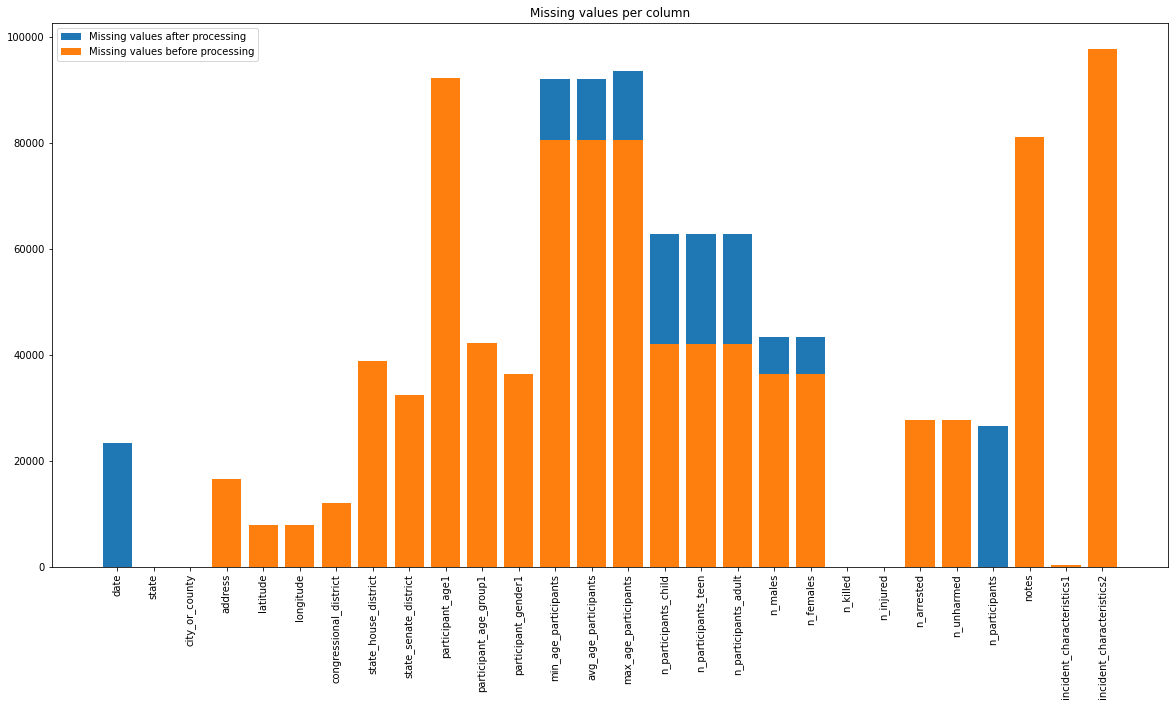

In [59]:
plt.figure(figsize=(20,10))
plt.bar(df.columns, df.isnull().sum(), label='Missing values after processing')
plt.bar(df.columns, nullCount_beforeProcessing, label='Missing values before processing')
plt.title('Missing values per column')
plt.legend()
plt.xticks(rotation=90)
plt.show()